## Model Selection Notebook

This notebook will perform model selection on a Kernel SVM to predict binary classification

- Home Win Result
- Not Home Win Result

In [67]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import sem
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import random
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import sem

numFolds = 10

date = '20170217'

In [3]:
# Load data
data = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/%s_Matches_w_Features.csv'%(date))

In [4]:
for col in data.columns:
    if data[col].dtype == 'object':
        print col

In [5]:
print len(data)
print data.shape

2280
(2280, 196)


In [6]:
home_goals = data['home_team_goal']
away_goals = data['away_team_goal']

In [7]:
del data['home_team_goal']
del data['away_team_goal']

In [8]:
print data.shape

(2280, 194)


In [9]:
## First step is to set up training and holdout set
def Assign_Train_Test(df):
    num = random.randint(1,numFolds)
    return num

In [10]:
data['Train_Test'] = data.apply(Assign_Train_Test, axis = 1)

In [11]:
## Chose holdout set as approx 10% of data
holdout = data[data['Train_Test']==1]
train = data[data['Train_Test']!= 1]

# Remove the train_test variable from the dataframes
del holdout['Train_Test']
del train['Train_Test']

print 'Test length ' + str(len(holdout))
print 'Train length ' + str(len(train))

Test length 178
Train length 2102


In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [19]:
def FitPredict(x_train,y_train,x_test,model):
    
    fit_model = model.fit(x_train,y_train)
    preds = fit_model.predict(x_test)
    
    return preds

def ComputeErrorMetric(y_true,y_pred):
    
    #df = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    # draw
    #hw_fp = ((df.y_true != 1) & (df.y_pred == 1))
    #hw_tp = ((df.y_true == 1) & (df.y_pred == 1))
    #hw_fn = ((df.y_true == 1) & (df.y_pred != 1))
    #hw_tn = ((df.y_true != 1) & (df.y_pred != 1))

    #true_positive = sum(hw_tp)
    #false_positive = sum(hw_fp)
    #true_negative = sum(hw_tn)
    #false_negative = sum(hw_fn)

    #combined_error_metric = 10.0/13.0*false_positive/(false_positive+true_negative)+3.0/13.0*false_negative/(false_negative+true_positive)
    
    #precision = true_positive / (true_positive + false_positive)
    #recall = true_positive / (true_positive + false_negative)
    
    f1score = f1_score(y_true,y_pred, average='binary')
    precision = precision_score(y_true,y_pred, average='binary')
    recall = recall_score(y_true,y_pred, average = 'binary')
    
    return round(f1score,2), round(precision,4), round(recall,2)

In [20]:
## Use Assign_Train_Test to assign cross-validation folds

train['Fold'] = train.apply(Assign_Train_Test,axis = 1)

train['Fold'].value_counts()   #All folds are approximately equal size

/Users/mtetkosk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


3     217
2     217
8     215
5     213
10    213
4     213
6     209
9     208
1     206
7     191
Name: Fold, dtype: int64

In [74]:
verbose = True

In [76]:
## Set up cross-validation loop

cv_accuracy = []
cv_precision = []
cv_recall = []

#kernel_choice = ['rbf','poly','sigmoid']
decision_function_shapes = ['ovo','ovr']
gamma_list = [0.1,.1,.5,1]

outer_param_scores = {}
outer_error_metric = []

summary_error = pd.DataFrame()


for fold in range(1,numFolds+1):
    
    # Outer Cross-Validation
    
    cv_train = train[train['Fold'] != fold]
    cv_test = train[train['Fold'] == fold]
    
    del cv_train['Fold']
    del cv_test['Fold']
    
    y_train = cv_train['Result_Target'].copy()
    x_train = cv_train.copy()
    del x_train['Result_Target']

    
    y_test = cv_test['Result_Target'].copy()
    del cv_test['Result_Target']
    x_test = cv_test.copy()
    
    # Set up inner cross-validation
    
    inner_train = cv_train.copy()
    del cv_train['Result_Target']
    
    inner_train['Inner_Fold'] = inner_train.apply(Assign_Train_Test, axis = 1)
    
    best_hyper_params = {}
    #se = {}
    
    paramComboDict = {}
    error_dict = {}
    outerfold = []
    inner_average = []
    paramnum = []
    paramComboNum = 0
    
    # Iterate thru hyperparameter search
    for k in decision_function_shapes:
        #if k == 'poly':
        #    gamma_list = [2,3,4]
        #else:
        #    gamma_list = [.01,.1,.2,.5,1]
        for g in gamma_list:
            
            paramComboNum += 1
            paramComboDict[paramComboNum] ={'gamma': g,
                                            'kernel': k}
            if verbose:
                print paramComboNum
                
            error_metric = []
    
            for inner_fold in range(1,numFolds+1):
            
                #print 'Inner Fold: ' + str(inner_fold)
        
                inner_cv_train = inner_train[inner_train['Inner_Fold']!= inner_fold]
                inner_cv_test = inner_train[inner_train['Inner_Fold']== inner_fold]
        
                del inner_cv_train['Inner_Fold']
                del inner_cv_test['Inner_Fold']
        
                y_inner_train = inner_cv_train['Result_Target']
                del inner_cv_train['Result_Target']
                x_inner_train = inner_cv_train.copy()
    
                y_inner_test = inner_cv_test['Result_Target']
                del inner_cv_test['Result_Target']
                x_inner_test = inner_cv_test.copy()
                
                clf = SVC(kernel = 'poly',degree = 2, class_weight = 'balanced',gamma = g, decision_function_shape = k)
                #if k == 'poly':
                #    clf = SVC(kernel = 'poly',degree = g, class_weight = 'balanced')
                #else:
                #    clf = SVC(kernel = k,gamma = g)
                
                preds = FitPredict(x_inner_train,y_inner_train,x_inner_test,clf)
    
                cem, precision,recall = ComputeErrorMetric(y_inner_test,preds)  # Calculate combined error metric
        
                error_metric.append(precision)
              
                #if cem > 0:
                #print 'Precision = ' + str(precision) + ' | ' + 'Recall = ' + str(recall)
                    
            
            avg_error_metric = np.mean(error_metric)
            em_std_err = sem(error_metric)
            
            print 'Fold ' + str(fold) + ' Param Combo Number ' + str(paramComboNum) + ' Avg Precision = ' + str((avg_error_metric - em_std_err))
            outerfold.append(fold)
            inner_average.append(avg_error_metric - em_std_err)
            paramnum.append(paramComboNum)
    
    
    if 'outerfold' in summary_error.columns and'inner_average' in summary_error.columns and 'paramnum' in summary_error.columns:
        temp_df = pd.DataFrame({'outerfold':outerfold,'inner_average':inner_average,'paramnum':paramnum})
        summary_error = pd.concat([summary_error, temp_df])    
    else:   
        summary_error['outerfold'] = outerfold
        summary_error['inner_average'] = inner_average
        summary_error['paramnum'] = paramnum
    
    sub = summary_error[summary_error['outerfold']==fold]
        
    best_params = paramComboDict[sub['paramnum'][sub['inner_average'].idxmax()]]
    
    k = best_params['kernel']
    g = best_params['gamma']
    
    print 'Best Params for Outer Fold ' + str(fold) + ' | ' + 'Decision Function = ' + str(k) + ' | ' + 'gamma = ' + str(g)
    
    clf = SVC(kernel = 'poly',degree = 2, class_weight = 'balanced',gamma = float(g), decision_function_shape = k)    
    
    #if k == 'poly':
    #    clf = SVC(kernel = k, degree = float(g))
    #else:
    #    clf = SVC(kernel = k, gamma = float(g))
    
    preds = FitPredict(x_train,y_train,x_test,clf)
    
    cem, precision,recall = ComputeErrorMetric(y_test,preds)
    
    outer_error_metric.append(precision)
    
    print 'Fold ' + str(fold) + ' Error Metric: ' + str(round(precision,2))
    
    outer_param_scores[sub['paramnum'][sub['inner_average'].idxmax()]] = precision

for key in outer_param_scores.keys():
    if outer_param_scores[key] == max(outer_param_scores.values()):
        best_combo = key
        
best_params = paramComboDict[best_combo]

best_k = best_params['kernel']
best_gamma = best_params['gamma']

avg_error_metric = np.mean(outer_error_metric)   
    
    
print '****************************************************'
print 'Average Error Metric= ' + str(avg_error_metric)
print 'Best Parameters: ' + ' Decision_Function = ' + str(best_k) + 'Gamma = ' + str(best_gamma)

Fold 1 Param Combo Number 1 Avg Precision = 0.518869159643
Fold 1 Param Combo Number 2 Avg Precision = 0.518869159643
Fold 1 Param Combo Number 3 Avg Precision = 0.521413074037
Fold 1 Param Combo Number 4 Avg Precision = 0.521413074037
Fold 1 Param Combo Number 5 Avg Precision = 0.518869159643
Fold 1 Param Combo Number 6 Avg Precision = 0.518869159643
Fold 1 Param Combo Number 7 Avg Precision = 0.521413074037
Fold 1 Param Combo Number 8 Avg Precision = 0.521413074037
Best Params for Outer Fold 1 | Decision Function = ovo | gamma = 0.5
Fold 1 Error Metric: 0.6
Fold 2 Param Combo Number 1 Avg Precision = 0.534079655747
Fold 2 Param Combo Number 2 Avg Precision = 0.534079655747
Fold 2 Param Combo Number 3 Avg Precision = 0.534850136796
Fold 2 Param Combo Number 4 Avg Precision = 0.534850136796
Fold 2 Param Combo Number 5 Avg Precision = 0.534079655747
Fold 2 Param Combo Number 6 Avg Precision = 0.534079655747
Fold 2 Param Combo Number 7 Avg Precision = 0.534850136796
Fold 2 Param Combo Nu

## Test on holdout set

In [77]:
## Prepare for test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

x_train = train.copy()
x_test = holdout.copy()

y_train = x_train['Result_Target']
del x_train['Result_Target']
del x_train['Fold']

y_test = x_test['Result_Target']
del x_test['Result_Target']

clf = SVC(kernel = 'poly',degree = 2, class_weight = 'balanced',gamma = .1, decision_function_shape = 'ovo')

preds = FitPredict(x_train,y_train,x_test,clf)
cem, precision, recall = ComputeErrorMetric(y_test,preds)

print 'Holdout Set Error Metric = ' + str(round(precision,2))
print 'Precision = ' + str(precision)
#print 'Recall = ' + str(recall)

## Metric to beat = 0.5301
## Metric after optimizing gamma / decision_function = .5465

Holdout Set Error Metric = 0.55
Precision = 0.5465


In [78]:
df_confusion = pd.crosstab(y_test,preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0.0,1.0,All
Actual,,,
0.0,55,39,94
1.0,37,47,84
All,92,86,178


### Finally, build model based off of entire dataset

In [79]:
x_train = data.copy()

y_train = x_train['Result_Target'].copy()
del x_train['Result_Target']

clf = SVC(kernel = 'poly', degree = 2)

fit_clf = clf.fit(x_train,y_train)

In [80]:
with open('/Users/mtetkosk/Google Drive/Data Science Projects/models/%s_SVC_Model_Champion.pkl'%(date), 'wb') as f:
    pickle.dump(fit_clf, f)

## Output Results

In [81]:
Results_Df = pd.DataFrame({'Date': date, 'Holdout Precision': precision, 'Kernel': best_k, 'Degree': best_gamma}, index=[0])

Results_Df.to_csv('/Users/mtetkosk/Google Drive/Data Science Projects/models/%s_SVM_Model_Champion.csv'%(date))

## Betting Analysis

In [82]:
test_home_odds = x_test['Average_Home_Odds'].copy()
test_away_odds = x_test['Average_Away_Odds'].copy()
draw_odds = x_test['Average_Draw_Odds'].copy()
bet_preds = preds.copy()
actual_results = y_test.copy()

In [83]:
Betting_df = pd.DataFrame({'Home_Odds':test_home_odds,'Away_Odds':test_away_odds,'Draw_Odds': draw_odds,'Model_Preds':bet_preds,'Result': y_test.copy()})
Betting_df = Betting_df.reset_index(drop=True)
Betting_df[Betting_df['Model_Preds']==1][:25]

,Away_Odds,Draw_Odds,Home_Odds,Model_Preds,Result
0,14.83,5.70,1.19,1.0,1.0
2,14.50,5.97,1.20,1.0,1.0
4,3.41,3.23,2.17,1.0,1.0
5,3.05,3.25,2.21,1.0,0.0
8,9.83,4.61,1.32,1.0,1.0
12,4.21,3.45,1.85,1.0,1.0
13,7.37,4.11,1.45,1.0,1.0
14,17.42,6.88,1.14,1.0,1.0
15,8.85,4.15,1.39,1.0,1.0
19,1.29,4.97,10.83,1.0,0.0


In [84]:
## Betting Analysis Function

def BettingAnalysis(df,purse,bet):
    initial_purse = purse
    purse_track = []
    for match in range(len(df)):
        pred = df['Model_Preds'][match]
        result = df['Result'][match]
        home_odds = df['Home_Odds'][match]
        away_odds = df['Away_Odds'][match]
        draw_odds = df['Draw_Odds'][match]
        if pred == 0:
            continue
        if pred == 1 and pred == result:
            #if pred == 1:
            #    win = round(bet*home_odds,2)-bet
            #    purse += win
            #if pred == -1: #simulate no bet
            #    win = round(bet*away_odds,2)-bet
            #    purse += win
            #purse_track.append(purse)
            if pred == 1:
                win = round(bet*home_odds,2)-bet
                assert win > 0
                purse += win
        else:
            purse = purse - bet
            purse_track.append(purse)
    
    if purse > initial_purse:
        profit = purse-initial_purse
        #return 'You profited ' +str(round(profit,2)) +'!'
        return purse_track
    if purse == initial_purse:
        #return 'You broke even!'
        return purse_track
    if purse < initial_purse:
        loss = purse-initial_purse
        #return 'You lost ' + str(abs(round(loss,2))) + 'now you\'re broke!'
        return purse_track

In [85]:
purse_track = BettingAnalysis(Betting_df,100,5)

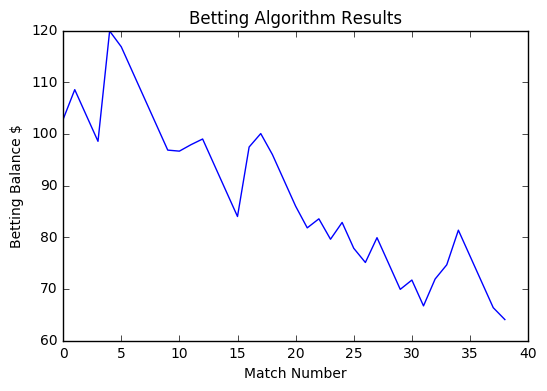

In [86]:
plt.plot(purse_track)
plt.xlabel('Match Number')
plt.ylabel('Betting Balance $')
plt.title('Betting Algorithm Results')

## Analysis of Mis-classified Games

In [88]:
# Get misclassified games

x_test['predicted'] = preds
x_test['actal'] = y_test

In [98]:
mis_classified_matches = x_test[(x_test.predicted == 1) & (x_test.actal != 1)]
correctly_classified_matches = x_test[(x_test.predicted == 1) & (x_test.actal == 1)]
mis_classified_matches.shape

(39, 195)

In [105]:
mis_classified_matches.columns[55:90]

Index([u'Home_Standing', u'Away_Standing', u'Home_Goal_Diff',
       u'Away_Goal_Diff', u'Standing_Diff', u'Diff_Goal_Diff',
       u'Average_Home_Odds', u'Average_Away_Odds', u'Average_Draw_Odds',
       u'away_last_2_concede', u'away_last_2_scored', u'home_last_2_conceded',
       u'home_last_2_scored', u'away_last_3_concede', u'away_last_3_scored',
       u'home_last_3_conceded', u'home_last_3_scored', u'away_last_4_concede',
       u'away_last_4_scored', u'home_last_4_conceded', u'home_last_4_scored',
       u'away_last_5_concede', u'away_last_5_scored', u'home_last_5_conceded',
       u'home_last_5_scored', u'Monday', u'Tuesday', u'Wednesday', u'Thursday',
       u'Friday', u'Saturday', u'Sunday', u'buildUpPlaySpeed_x',
       u'buildUpPlayPassing_x', u'chanceCreationPassing_x'],
      dtype='object')

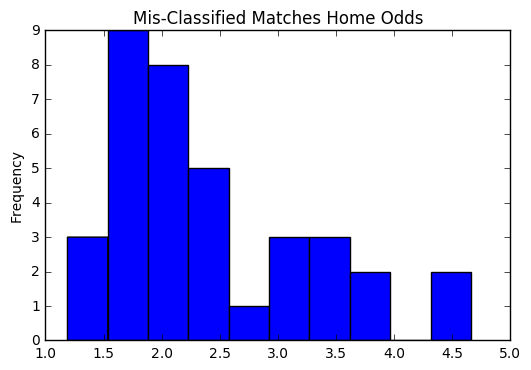

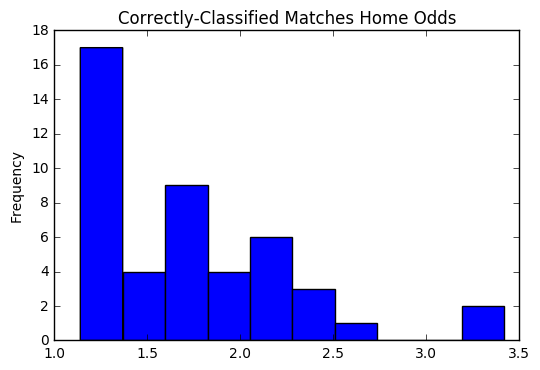

In [101]:
# Let's look at the odds

mis_classified_matches[mis_classified_matches['Average_Home_Odds'] < 5]['Average_Home_Odds'].plot(kind='hist')
plt.title('Mis-Classified Matches Home Odds')
plt.show()

correctly_classified_matches[correctly_classified_matches['Average_Home_Odds'] < 5]['Average_Home_Odds'].plot(kind='hist')
plt.title('Correctly-Classified Matches Home Odds')
plt.show()

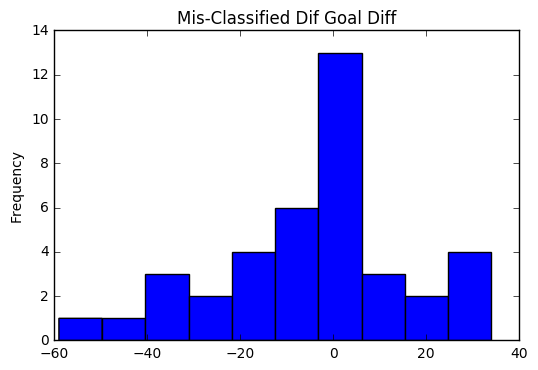

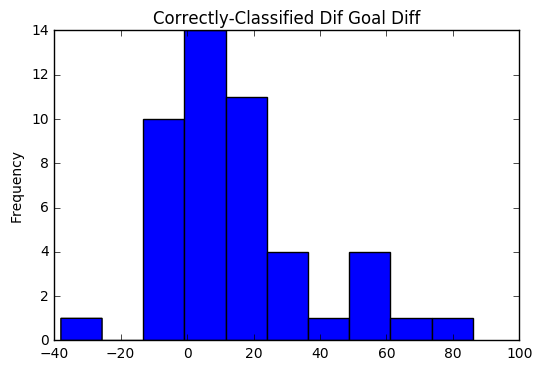

In [104]:
# Let's look at diff goal differences

mis_classified_matches['Diff_Goal_Diff'].plot(kind='hist')
plt.title('Mis-Classified Dif Goal Diff')
plt.show()

correctly_classified_matches['Diff_Goal_Diff'].plot(kind='hist')
plt.title('Correctly-Classified Dif Goal Diff')
plt.show()

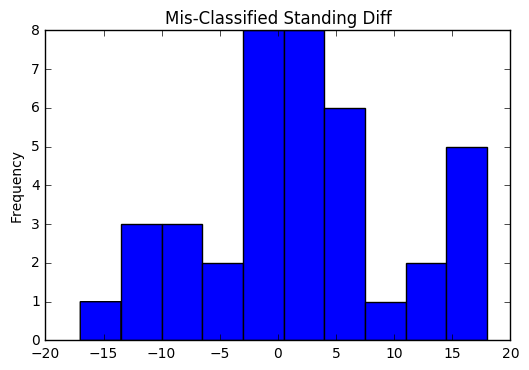

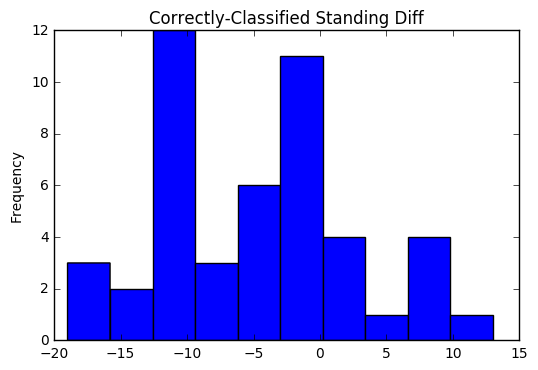

In [106]:
# Let's look at standing differences

mis_classified_matches['Standing_Diff'].plot(kind='hist')
plt.title('Mis-Classified Standing Diff')
plt.show()

correctly_classified_matches['Standing_Diff'].plot(kind='hist')
plt.title('Correctly-Classified Standing Diff')
plt.show()